In [24]:
import requests
import pandas as pd
import json
import numpy as np
from scipy.spatial.distance import cdist
import os
from datetime import timedelta
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, LineString,Point, box
from kloppy import skillcorner
from kloppy.domain import Team
from kloppy.domain import Orientation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from urllib.request import urlopen
from highlight_text import fig_text
from matplotlib.animation import FuncAnimation
import re
import random

from PIL import Image

from mplsoccer import PyPizza, add_image, FontManager


# Setup pitch and plot
from mplsoccer import Pitch
#from mplsoccer.pitch import Pitch ,VerticalPitch

# username = "XXX"
# password = "XXX"


# from skillcorner.client import SkillcornerClient
# client=SkillcornerClient(username=username,password=password)

def time_to_seconds(time_str):
    if time_str is None:
        return 90 * 60  # 120 minutes = 7200 seconds
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

font_normal = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Regular.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Italic.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
                        'RobotoSlab[wght].ttf')

In [2]:
def load_matches(matches_json_path):

    with open(matches_json_path, "r") as f:
        matches_json = json.load(f)

    match_ids = [match["id"] for match in matches_json]

    all_tracking = []

    for match_id in match_ids:
        tracking_data_github_url = f'https://media.githubusercontent.com/media/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl'
        
        dataset = skillcorner.load(
            meta_data=f'https://raw.githubusercontent.com/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_match.json',
            raw_data=tracking_data_github_url,
            # Optional arguments,
            coordinates="skillcorner",
            include_empty_frames=False)
        
        dataset.transform(to_orientation = Orientation.STATIC_HOME_AWAY)

        all_tracking.append(dataset)

    all_de_dfs = []

    for match_id in match_ids:
        url = f"https://raw.githubusercontent.com/SkillCorner/opendata/master/data/matches/{match_id}/{match_id}_dynamic_events.csv"
        try:
            de_match = pd.read_csv(url)
            all_de_dfs.append(de_match)
        except Exception as e:
            print(f"Failed to load dynamic events for match {match_id}: {e}")

    de_all_matches = pd.concat(all_de_dfs, ignore_index=True)

    all_metadata = []

    for match_id in match_ids:
        metadata_match = f'https://raw.githubusercontent.com/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_match.json'
        response = requests.get(metadata_match)
        raw_match_data = response.json()
        all_metadata.append(raw_match_data)

    
    return all_tracking, de_all_matches, all_metadata
        

In [3]:
# Load matches

matches_json_path = os.path.join(os.path.dirname(os.getcwd()), "data/matches.json")
all_tracking, de_all_matches, all_metadata = load_matches(matches_json_path)

C:\Users\g4a4b\AppData\Local\Temp\ipykernel_12840\480536238.py:29: DtypeWarning: Columns (75,77,184,264) have mixed types. Specify dtype option on import or set low_memory=False.
  de_match = pd.read_csv(url)
C:\Users\g4a4b\AppData\Local\Temp\ipykernel_12840\480536238.py:29: DtypeWarning: Columns (276) have mixed types. Specify dtype option on import or set low_memory=False.
  de_match = pd.read_csv(url)


In [4]:
def midfielders_obe(de_all_matches):
    # Get off-ball events
    off_ball_events = de_all_matches[de_all_matches["event_type_id"] == 1]

    # Get only off ball events from midfielders
    positions_mid = [9,10,11,12,13,14,15]
    mid_obe = off_ball_events[off_ball_events["player_position_id"].isin(positions_mid)].copy()

    # For every obe, column id equals event_id_match_id
    mid_obe["id"] = mid_obe["event_id"].astype(str) + "_" + mid_obe["match_id"].astype(str)
    mid_obe = mid_obe.reset_index(drop=True)

    # Data matching
    mid_obe = mid_obe[
            (mid_obe["is_player_possession_start_matched"] == True) &
            (mid_obe["is_player_possession_end_matched"] == True)
        ]
    return mid_obe

In [5]:
def get_time_from_frame(all_tracking, match_id, frame_id):
    for tracking in all_tracking:
        if int(tracking.metadata.game_id) == int(match_id):
            for frame in tracking:
                if int(frame.frame_id) == int(frame_id):
                    time_str = str(frame.time)  # e.g. "P1T00:09" or "P2T03:21"

                    # Extract period, minutes and seconds
                    match = re.match(r"P(\d+)T(\d+):(\d+)", time_str)
                    period = int(match.group(1))
                    minutes = int(match.group(2))
                    seconds = int(match.group(3))

                    # Base time from mm:ss
                    td = pd.Timedelta(minutes=minutes, seconds=seconds)

                    # If second period, add 45 minutes
                    if period == 2:
                        td += pd.Timedelta(minutes=45)

                    return td

In [14]:
mid_obe = midfielders_obe(de_all_matches)
    
# get the 10th row
example = mid_obe.iloc[9]
print(example["associated_player_possession_event_id"])
print(example["match_id"])
print(example["associated_player_possession_frame_start"])
frame_start = example["frame_start"]

pp = de_all_matches[
    (de_all_matches["event_id"] == example["associated_player_possession_event_id"]) &
    (de_all_matches["match_id"] == example["match_id"])
]

p_options = de_all_matches[
    (de_all_matches["event_type_id"] == 7) &
    (de_all_matches["match_id"] == example["match_id"])]

# get the passing options that occurs during -0.5seconds to +5 seconds of the possession start
p_options = p_options[(
    (pd.to_datetime(pp["time_start"])) >= pd.to_datetime(p_options["time_start"]) & pd.to_datetime(pp["time_start"]) < pd.to_datetime(p_options["time_end"]))   
]
print(p_options["second_start"].values)
print(p_options.shape[0])


print(pp["frame_start"].values[0])
print(pp["n_passing_options_at_start"].values[0])
print(pp["second_start"].values[0])

8_65
2017461
5887.0


DateParseError: hour must be in 0..23: 24:07.4, at position 399

In [44]:

columns = ["event_id", "player_id","match_id","frame_start","frame_end","simultaneous_runs","po_created",
           "n_dangerous","n_first_line", "n_second_last_line", "n_last_line"]
po_df = pd.DataFrame(columns=columns)

for idx, row in mid_obe.iterrows():
    frame_start = row["frame_start"]
    frame_end = row["frame_end"]
    match_id = row["match_id"]

    if row['n_simultaneous_runs'] > 0:
        simultaneous_runs = True
    else:
        simultaneous_runs = False

    # get passion options events that the start frame is between frame_start and frame_end
    p_options = de_all_matches[
        (de_all_matches["event_type_id"] == 7) &
        (de_all_matches["match_id"] == match_id) &
        (de_all_matches["frame_start"] >= frame_start) &
        (de_all_matches["frame_start"] <= frame_end)
    ]

    true_p_o_count = (p_options['predicted_passing_option'] == True).sum()

    dangerous_count = (p_options['dangerous'] == True).sum()

    # for the column furthest_line_break, there are 4 options: first_line, second_last_line, last_line, none. get the counts for each option
    grouped = p_options.groupby('furthest_line_break').size()
    first_line_count = grouped.get('first_line', 0)
    second_last_line_count = grouped.get('second_last_line', 0) 
    last_line_count = grouped.get('last_line', 0)
    none_count = grouped.get('none', 0)

    po_df = pd.concat([po_df, pd.DataFrame([{
        "event_id": row["event_id"],
        "player_id": row["player_id"],
        "match_id": match_id,
        "frame_start": frame_start,
        "frame_end": frame_end,
        "simultaneous_runs": simultaneous_runs,
        "po_created": true_p_o_count,
        "n_dangerous": dangerous_count,
        "n_first_line": first_line_count,
        "n_second_last_line": second_last_line_count,
        "n_last_line": last_line_count
    }])], ignore_index=True)

    
print(po_df.shape)

print(po_df[(po_df['po_created'] > 0) & (po_df["simultaneous_runs"] == False)].shape)

(1271, 11)
(505, 11)


In [33]:
mid_obe = po_created(mid_obe, de_all_matches)

# Count n_passing_options_during and n_dangerous_not_difficult_during
for idx, row in mid_obe.head(20).iterrows():
    print(row['n_passing_options_during'], row['n_dangerous_not_difficult_during'])

3.0 0.0
2.0 0.0
2.0 0.0
2.0 1.0
5.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
2.0 0.0
4.0 2.0
2.0 0.0
2.0 0.0
3.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
3.0 2.0
0.0 0.0
0.0 0.0
3.0 0.0


I get the coordinates of the runner in the beginning of the run and the coordinates in the end of the run. Then, I get the coordinates of the player in possesion. Then I draw a line between the coordinates of the runner at the start and the coordinates of the player in possession. I also draw a line from the player in possesion to the coordinates in the end of the run. This two lines form an angle with the coordinates of the player in possession. Then I count all the passing options that are created inside this angle. If the run is horizontal is perfect. If the run is vertical (I can define a threshold), then I get the whole third or a predefined radius. Also add a distance threshold because the runner can move orizontally close to the player in possesion and suddenly there is a run inside the angle but its waaay far from the runner and that would mean that he didnt influence much.

Get the coordinates of the runner at start time. The pp at start time too. Then coordinates of the runner at end time. If end time the pp doesnt have the ball, get the last frame where the pp have the ball. Then get the coordinates of the runner at that frame. Like this we will have the accurate angle of the runner with the pp. 

If the pp lost the ball, then thats it. If the ball goes to another player, there is a new event for that.

This might be good and also can be visualized well!

In [ ]:
run = mid_obe.iloc[1]

# get the coordinates of the run at the start
start_x = run['x_start']
start_y = run['y_start']
player_id = run['player_id']
frame_start = run['frame_start']
frame_end = run['frame_end']
p_p_x = run["player_in_possession_x_start"]
p_p_y = run["player_in_possession_y_start"]
p_p_event_id = run["associated_player_possession_event_id"]
match_id = run["match_id"]

p_p_event = de_all_matches[
    (de_all_matches["event_id"] == p_p_event_id) &
    (de_all_matches["match_id"] == match_id)
]
p_p_frame_start = p_p_event["frame_start"].values[0]
p_p_frame_end = p_p_event["frame_end"].values[0]
end_type = p_p_event["end_type"].values[0]

if end_type == "pass":
    if p_p_event["pass_outcome"].values[0] == "successful":
        targeted_passing_option_event_id = p_p_event["targeted_passing_option_event_id"].values[0]


nan


In [6]:
def coordinates_at_frame(all_tracking, match_id, player_id, frame_id):
    #print(frame_id)
    for tracking in all_tracking:
        if int(tracking.metadata.game_id) == int(match_id):
            for frame in tracking:
                if int(frame.frame_id) == int(frame_id):
                    for player, player_coordinates in frame.players_coordinates.items():
                        if int(player.player_id) == int(player_id):
                            return player_coordinates.x, player_coordinates.y
    return None, None

In [ ]:
mid_obe = midfielders_obe(de_all_matches)
print(len(mid_obe))

for n in range(25):
     example = mid_obe.sort_values(by="time_start", ascending=True).iloc[n]
     x,y = coordinates_at_frame(all_tracking, example["match_id"], example["player_id"], example["frame_start"])
     print("idx and time:",n, example["time_start"])
     print("x and y in event data:", x, y)
     print("coordinates in kloppy tracking data:", example["x_start"], example["y_start"])

print("-----")


for n in range(800,825):
     example = mid_obe.sort_values(by="time_start", ascending=True).iloc[n]
     x,y = coordinates_at_frame(all_tracking, example["match_id"], example["player_id"], example["frame_start"])
     print("idx and time:",n, example["time_start"])
     print("x and y:", x, y)
     print("coordinates:", example["x_start"], example["y_start"])


1271
idx and time: 0 00:01.3
x and y in event data: None None
coordinates in kloppy tracking data: 4.51 17.39
idx and time: 1 00:01.9
x and y in event data: None None
coordinates in kloppy tracking data: -8.85 4.2
Ball owning team in the frame: Melbourne City FC
Player team: Melbourne City FC
idx and time: 2 00:03.1
x and y in event data: 1.78 7.53
coordinates in kloppy tracking data: -1.78 -7.53
Ball owning team in the frame: Auckland FC
Player team: Wellington Phoenix FC
idx and time: 3 00:04.7
x and y in event data: -9.98 0.48
coordinates in kloppy tracking data: -9.98 0.48
Ball owning team in the frame: Newcastle United Jets FC
Player team: Newcastle United Jets FC
idx and time: 4 00:07.1
x and y in event data: 14.25 12.68
coordinates in kloppy tracking data: 14.25 12.68
Ball owning team in the frame: Melbourne Victory Football Club
Player team: Melbourne Victory Football Club
idx and time: 5 00:09.0
x and y in event data: -3.83 -4.99
coordinates in kloppy tracking data: -3.83 -4.9

In [7]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Arc

pitch = Pitch(
    pitch_type="skillcorner",
    pitch_length=105,
    pitch_width=68,
    pitch_color="#001400",
    line_color="white",
    linewidth=1.5
)

def draw_angle(ax, center, v1, v2, color, label=None, radius=10):
    a1 = np.degrees(np.arctan2(v1[1], v1[0]))
    a2 = np.degrees(np.arctan2(v2[1], v2[0]))

    # Normalize to [0, 360)
    a1 = (a1 + 360) % 360
    a2 = (a2 + 360) % 360

    # Smallest angle direction
    diff = (a2 - a1 + 360) % 360
    if diff > 180:
        a1, a2 = a2, a1
        diff = 360 - diff

    arc = Arc(center, radius*2, radius*2,
              angle=0, theta1=a1, theta2=a1 + diff,
              color=color, lw=2)
    ax.add_patch(arc)

    # get the value of the angle
    angle_value = diff

    if label:
        mid = np.radians(a1 + diff / 2)
        ax.text(center[0] + (radius + 2) * np.cos(mid),
                center[1] + (radius + 2) * np.sin(mid),
                diff,
                color=color, fontsize=10, weight="bold")

        
def rotate_vector(v, theta_deg):
    """Rotate 2D vector v by theta_deg degrees"""
    theta = np.radians(theta_deg)
    rot_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                           [np.sin(theta),  np.cos(theta)]])
    return rot_matrix @ v

def plot_frame_debug_skillcorner(p_p_pos, start_pos, runner_pos, po_pos=None,
                                 angle=None, angle_po=None, frame_id=None,
                                 angle_offset=25, new_v1=None, new_v2=None):

    fig, ax = pitch.draw(figsize=(10, 7))

    # --- Scatter points ---
    pitch.scatter(*p_p_pos, ax=ax, color="red", s=130, zorder=5, label="Possessor")
    pitch.scatter(*start_pos, ax=ax, color="blue", s=130, zorder=5, label="Runner Start")
    pitch.scatter(*runner_pos, ax=ax, color="lime", s=130, zorder=5, label="Runner Current")

    # --- Base vectors ---
    v_start = start_pos - p_p_pos
    v_runner = runner_pos - p_p_pos

    # --- Original vectors ---
    pitch.lines(p_p_pos[0], p_p_pos[1], start_pos[0], start_pos[1],
                ax=ax, color="purple", lw=2, label="Runner start vector")

    pitch.lines(p_p_pos[0], p_p_pos[1], runner_pos[0], runner_pos[1],
                ax=ax, color="lime", lw=2, label="Runner current vector")

    # ================================
    # WIDENED ANGLE VISUALIZATION
    # ================================

    scale = 12  # controls vector length on pitch

    new_end = p_p_pos + (new_v1 / np.linalg.norm(new_v1)) * scale

    # Draw dashed boundary vectors
    pitch.lines(p_p_pos[0], p_p_pos[1], new_end[0], new_end[1],
                ax=ax, color="cyan", lw=2, linestyle="--",
                label="Widened cone boundary")
    
    # ================================
    # WIDENED ANGLE VISUALIZATION
    # ================================

    scale = 12  # controls vector length on pitch

    new_end = p_p_pos + (new_v2 / np.linalg.norm(new_v2)) * scale

    # Draw dashed boundary vectors
    pitch.lines(p_p_pos[0], p_p_pos[1], new_end[0], new_end[1],
                ax=ax, color="cyan", lw=2, linestyle="--",
                label="Widened cone boundary")

    # DRAW WIDENED ARC
    draw_angle(ax, p_p_pos, new_v1, new_v2,
               color="cyan", label=f"Widened ±{angle_offset}°")

    # ================================
    # PASSING OPTION
    # ================================
    if po_pos is not None:
        pitch.scatter(*po_pos, ax=ax, color="orange", s=160, zorder=5, label="Passing Option")
        v_po = po_pos - p_p_pos

        pitch.lines(p_p_pos[0], p_p_pos[1], po_pos[0], po_pos[1],
                    ax=ax, color="orange", lw=2, label="PO vector")

        if angle is not None:
            draw_angle(ax, p_p_pos, v_start, v_runner, "magenta",
                       label=f"{angle:.1f}° (run)")

        if angle_po is not None:
            draw_angle(ax, p_p_pos, v_start, v_po, "gold",
                       label=f"{angle_po:.1f}° (PO)")

    ax.set_title(f"Passing Option Geometry - Frame {frame_id}",
                 fontsize=14, color="white")

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='lower right')

    plt.show()


     


In [57]:
def angle_between(v1, v2):
    unit_v1 = v1 / np.linalg.norm(v1)
    unit_v2 = v2 / np.linalg.norm(v2)
    dot = np.clip(np.dot(unit_v1, unit_v2), -1.0, 1.0)
    return np.degrees(np.arccos(dot))

def rotate_vector(v, theta_deg):
    """Rotate 2D vector v by theta_deg degrees"""
    theta = np.radians(theta_deg)
    rot_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                           [np.sin(theta),  np.cos(theta)]])
    return rot_matrix @ v

def side_sign(v1, v2):
    # v1 x v2 (2D cross product z-component)
    return np.sign(v1[0]*v2[1] - v1[1]*v2[0])

import numpy as np

def point_to_segment_distance(P, A, B):
    P = np.array(P)
    A = np.array(A)
    B = np.array(B)

    AB = B - A
    AP = P - A

    # projection factor of AP onto AB
    t = np.dot(AP, AB) / np.dot(AB, AB)

    # clamp t to stay on the segment [0, 1]
    t = max(0, min(1, t))

    closest_point = A + t * AB
    distance = np.linalg.norm(P - closest_point)

    return distance, closest_point

def is_po_inside_runner_cone(v_runner_start, v_runner_current, v_po_line):
        runner_cross = np.cross(v_runner_start, v_runner_current)
        cross1 = np.cross(v_runner_start, v_po_line)
        cross2 = np.cross(v_po_line, v_runner_current)
        if runner_cross > 0:
            return cross1 >= 0 and cross2 >= 0
        else:
            return cross1 <= 0 and cross2 <= 0

# Range of passing options created during the run
def range_po_created(run, p_options_run, de_all_matches, all_tracking):
    
    player_id = run['player_id']
    match_id = run["match_id"]
    frame_start = run['frame_start']
    frame_end = run['frame_end']
    trajectory_direction = run['trajectory_direction']
    p_p_event_id = run["associated_player_possession_event_id"]

    # runner coordinates at start of the run
    start_x, start_y = coordinates_at_frame(all_tracking, match_id, player_id, frame_start)
    start_pos = np.array([start_x, start_y])
    if start_x is None or start_y is None:
        print("Runner coordinates at start frame not found.")
        return pd.DataFrame()
    

    p_p_event = de_all_matches[
    (de_all_matches["event_id"] == p_p_event_id) &
    (de_all_matches["match_id"] == match_id)
    ]
    p_p_frame_end = p_p_event["frame_end"].values[0]
    p_p_player_id = p_p_event["player_id"].values[0]

    if p_p_frame_end < frame_end:
        print("Adjusting frame_end from", frame_end, "to", p_p_frame_end)
        frame_end = p_p_frame_end

    # Check for passing options in p_options_run that are in the new range between frame_start and frame_end
    range_po = p_options_run[
        (p_options_run["frame_start"] >= frame_start) &
        (p_options_run["frame_start"] <= frame_end)
    ] 

    angle_offset = 30  # degrees

    if range_po.empty:
        print("No passing options created during the run.")
        return range_po

    range_po = range_po.copy()
    range_po["created_during_run"] = False
        
    for frame_id in range(frame_start, frame_end + 1):
        # possessor coordinates at frame_id
        print("Analyzing frame:", frame_id)
        p_p_x,  p_p_y = coordinates_at_frame(all_tracking, match_id, p_p_player_id, frame_id)
        p_p_pos = np.array([p_p_x, p_p_y])

        # runner coordinates at frame_id
        runner_x, runner_y = coordinates_at_frame(all_tracking, match_id, player_id, frame_id)
        runner_pos = np.array([runner_x, runner_y])

        # ignore if runner hasn't moved
        if (runner_x == start_x and runner_y == start_y):
            continue

        # create two vectors: from (p_p_x, p_p_y) to (start_x, start_y) and from (p_p_x, p_p_y) to (runner_x, runner_y)
        v1 = start_pos - p_p_pos
        v2 = runner_pos - p_p_pos

        # vector movement and adding offset to both sides of the angle of the starting position
        v_movement = runner_pos - start_pos
        sign = side_sign(v1, v_movement)
        v_upper = rotate_vector(v1, -sign * angle_offset)
        v_lower = rotate_vector(v1, sign * angle_offset)
        angle_upper = angle_between(v_upper, v2)
        angle_lower = angle_between(v_lower, v2)

        if angle_upper > angle_lower:
            v1 = v_upper
        else:
            v1 = v_lower

        # adding offset to both sides of the angle of the current position
        sign = side_sign(v2, v_movement)
        v_upper_2 = rotate_vector(v2, -sign * angle_offset)
        v_lower_2 = rotate_vector(v2, sign * angle_offset)
        angle_upper_2 = angle_between(v1, v_lower_2)
        angle_lower_2 = angle_between(v1, v_upper_2)
        if angle_upper_2 < angle_lower_2:
            v2 = v_upper_2
        else:
            v2 = v_lower_2
        
        angle = angle_between(v1, v2)

        # check if any passing option created during the run is within the angle range
        for idx, po in range_po.iterrows():
            po_frame = po["frame_start"]

            if po["frame_start"] != frame_id:
                continue
            
            print(po["channel_start"], po["channel_end"])
            print("Frame matches passing option frame:", po_frame)
            print("Angle at frame", frame_id, ":", angle)
            # get passing option coordinates
            po_x, po_y = coordinates_at_frame(all_tracking, match_id, po["player_id"], po_frame)
            po_pos = np.array([po_x, po_y])
            # create vector from (p_p_x, p_p_y) to (po_x, po_y)
            v_po = po_pos - p_p_pos
            #angle_po = angle_between(v1, v_po)
            #print("Passing option at frame", po_frame, "angle:", angle_po)

            # check if passing option is inside the runner cone
            inside = is_po_inside_runner_cone(v1, v2, v_po)

            # check distance from passing option to runner current position and start position
            dist, _ = point_to_segment_distance(po_pos, start_pos, runner_pos)
            print("Distance from PO to runner path:", dist)

            close_enough = (dist <= 20)
            print("close enough:", close_enough)
            print("is passing option inside runner cone?", inside)
            
            plot_frame_debug_skillcorner(
            p_p_pos=p_p_pos,
            start_pos=start_pos,
            runner_pos=runner_pos,
            po_pos=po_pos,
            frame_id=frame_id,
            angle_offset=angle_offset,
            new_v1=v1,
            new_v2=v2)

            if inside and close_enough:
                print("    --> Passing option started within range at frame", po_frame)
                range_po.at[idx, "created_during_run"] = True
            elif run["event_subtype"] == "overlap":

                # We count passing options that appear in front of the player in possesion during overlap runs
                print(run["attacking_side"])

                # attack direction
                if run["attacking_side"] == "left_to_right":
                    v_attack = np.array([1.0, 0.0])
                else:  # 'right_to_left'
                    v_attack = np.array([-1.0, 0.0])

                v_po = po_pos - p_p_pos

                # check if passing option is in front of the possessor
                if np.dot(v_po, v_attack) <= 0:
                    in_front = False
                else:
                    in_front = True

                if in_front:
                    runner_pp_dist = np.linalg.norm(runner_pos - p_p_pos)
                    print("Distance between runner and possessor at frame", frame_id, ":", runner_pp_dist)
                    if runner_pp_dist < 10:
                        print("    --> Passing option started in front during overlap at frame", po_frame)
                        range_po.at[idx, "created_during_run"] = True
        
    # filter by created_during_run
    range_po = range_po[range_po["created_during_run"] == True]
        
    return range_po

In [9]:
## ------ NUMBER OF (DANGEROUS AND NOT DIFFICULT) PASSING OPTIONS CREATED ------ ##

## check the player_ids, event_ids because there might be duplicates and maybe we do not want that

def po_created(row, de_all_matches, all_tracking):
    
    frame_start = row["frame_start"]
    frame_end = row["frame_end"]
    match_id = row["match_id"]
    player_id = row["player_id"]
    event_id = row["event_id"]

    # During the run
    p_options_run = de_all_matches[
        (de_all_matches["event_type_id"] == 7) &
        (de_all_matches["match_id"] == match_id) &
        (de_all_matches["frame_start"] > frame_start) &
        (de_all_matches["frame_start"] < frame_end) &
        (de_all_matches["player_id"] != player_id)]
    print("Total passing options during the run before range filtering:", p_options_run.shape[0])
    print("Unique player IDs in passing options during the run:", p_options_run["player_id"].nunique())
    print("Unique event IDs in passing options during the run:", p_options_run["event_id"].nunique())
    # print the first 5 rows with these columns: event_id, player_id, frame_start, frame_end
    print(p_options_run[["event_id", "player_id", "frame_start", "frame_end","peak_passing_option_frame", "associated_player_possession_event_id"]].head(5))
    print("Associated player possession of the run:", row["associated_player_possession_event_id"])
    print(frame_start, frame_end)
    # call the range_po_created function
    p_options_run = range_po_created(row, p_options_run, de_all_matches, all_tracking)

    # if p_options_run not empty, 
    if not p_options_run.empty:
        print("Passing options created during the run:", p_options_run.shape[0])
        

        po_dang_not_diff = p_options_run[
            (p_options_run["peak_passing_option_frame"] >= frame_start) &
            (p_options_run["peak_passing_option_frame"] <= frame_end) &
            (p_options_run['dangerous'] == True) &
            (p_options_run['difficult_pass_target'] == False)
            ]
    else:
        po_dang_not_diff = pd.DataFrame()
                
    return p_options_run, po_dang_not_diff

Total passing options during the run before range filtering: 3
Unique player IDs in passing options during the run: 3
Unique event IDs in passing options during the run: 3
    event_id  player_id  frame_start  frame_end  peak_passing_option_frame  \
647    7_324     133498         9269       9297                     9296.0   
648    7_325     624628         9269       9299                     9297.0   
652    7_327      38673         9324       9333                     9316.0   

    associated_player_possession_event_id  
647                                 8_128  
648                                 8_128  
652                                 8_128  
Associated player possession of the run: 8_128
9253 9326
Analyzing frame: 9253
Analyzing frame: 9254
Analyzing frame: 9255
Analyzing frame: 9256
Analyzing frame: 9257
Analyzing frame: 9258
Analyzing frame: 9259
Analyzing frame: 9260
Analyzing frame: 9261
Analyzing frame: 9262
Analyzing frame: 9263
Analyzing frame: 9264
Analyzing frame: 9

C:\Users\g4a4b\AppData\Local\Temp\ipykernel_12840\1846246385.py:40: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  runner_cross = np.cross(v_runner_start, v_runner_current)
C:\Users\g4a4b\AppData\Local\Temp\ipykernel_12840\1846246385.py:41: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross1 = np.cross(v_runner_start, v_po_line)
C:\Users\g4a4b\AppData\Local\Temp\ipykernel_12840\1846246385.py:42: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross2 = np.cross(v_po_line, v_runner_current)


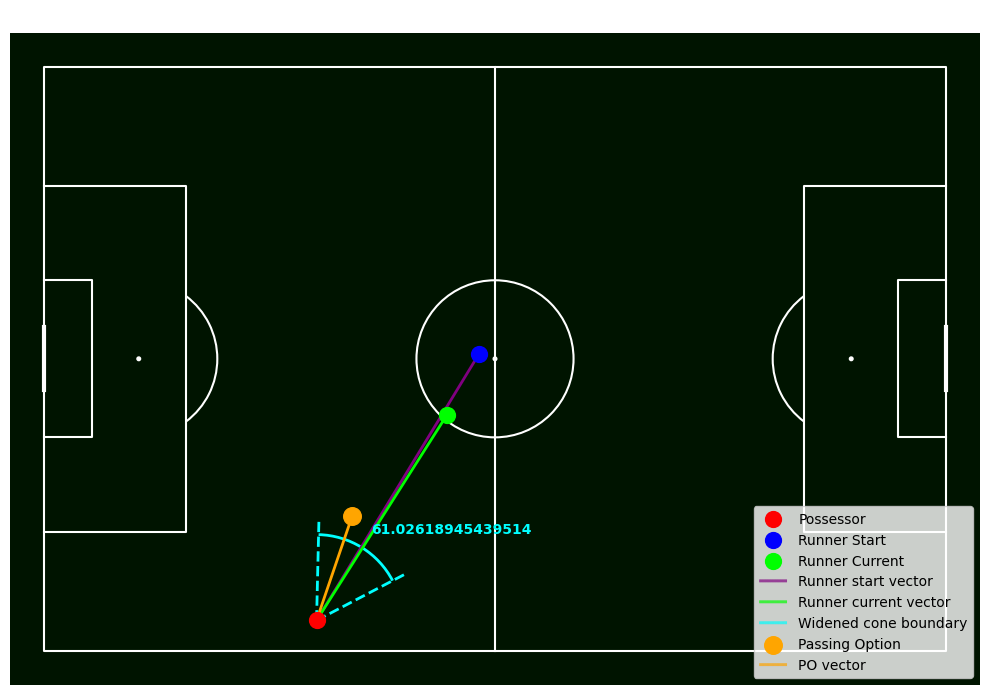

    --> Passing option started within range at frame 9269
half_space_left center
Frame matches passing option frame: 9269
Angle at frame 9269 : 61.02618945439514
Distance from PO to runner path: 22.42111727813759
close enough: False
is passing option inside runner cone? False


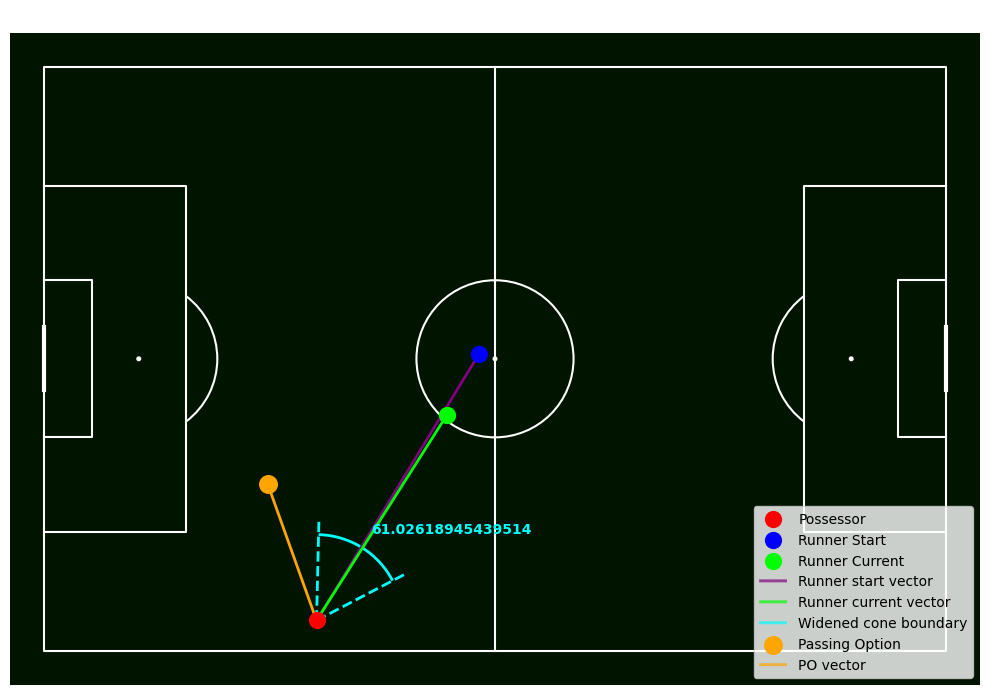

right_to_left
Distance between runner and possessor at frame 9269 : 28.410711008350354
Analyzing frame: 9270
Analyzing frame: 9271
Analyzing frame: 9272
Analyzing frame: 9273
Analyzing frame: 9274
Analyzing frame: 9275
Analyzing frame: 9276
Analyzing frame: 9277
Analyzing frame: 9278
Analyzing frame: 9279
Analyzing frame: 9280
Analyzing frame: 9281
Analyzing frame: 9282
Analyzing frame: 9283
Analyzing frame: 9284
Analyzing frame: 9285
Analyzing frame: 9286
Analyzing frame: 9287
Analyzing frame: 9288
Analyzing frame: 9289
Analyzing frame: 9290
Analyzing frame: 9291
Analyzing frame: 9292
Analyzing frame: 9293
Analyzing frame: 9294
Analyzing frame: 9295
Analyzing frame: 9296
Analyzing frame: 9297
Analyzing frame: 9298
Analyzing frame: 9299
Analyzing frame: 9300
Analyzing frame: 9301
Analyzing frame: 9302
Analyzing frame: 9303
Analyzing frame: 9304
Analyzing frame: 9305
Analyzing frame: 9306
Analyzing frame: 9307
Analyzing frame: 9308
Analyzing frame: 9309
Analyzing frame: 9310
Analyzing f

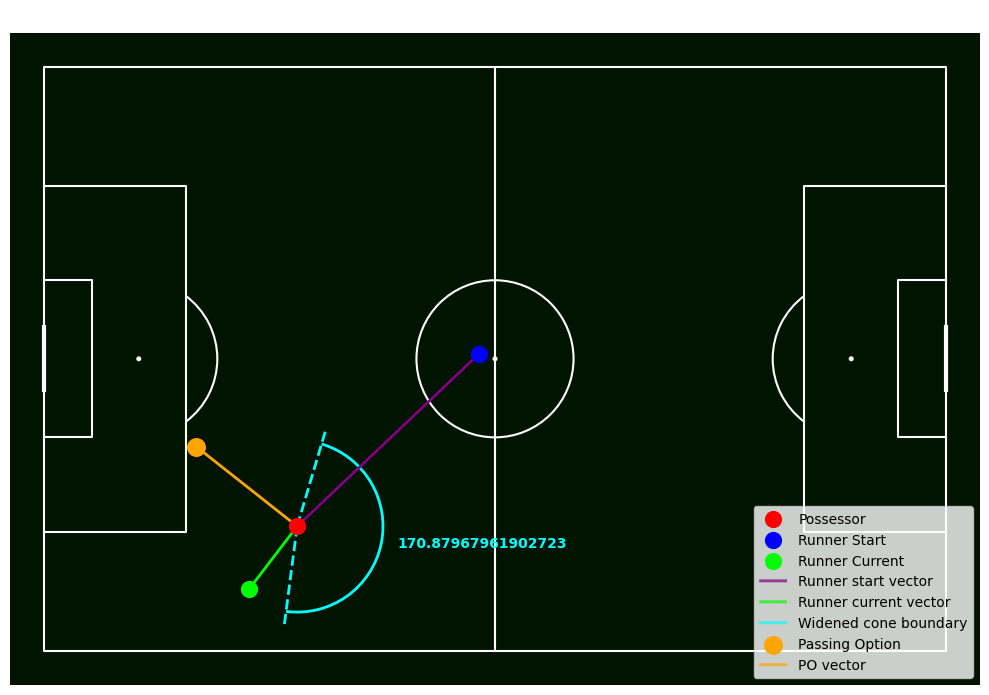

right_to_left
Distance between runner and possessor at frame 9324 : 9.202401860384057
    --> Passing option started in front during overlap at frame 9324
Analyzing frame: 9325
Analyzing frame: 9326
Passing options created during the run: 2
Total passing options created during the run: 2
Total dangerous and not difficult passing options created during the run: 1


In [58]:
# Maybe calculate the distance from the segment of the starting position of the runner and his current position
mid_obe = midfielders_obe(de_all_matches)
overlap = mid_obe[mid_obe["event_subtype"] == "overlap"]
overlap_left_to_right = overlap[overlap["attacking_side"] == "left_to_right"]
overlap_right_to_left = overlap[overlap["attacking_side"] == "right_to_left"]

example = overlap_right_to_left.iloc[0]

"""
for event_subtype in mid_obe["event_subtype"].unique():
    print("-------------------------------")
    print("Event subtype:", event_subtype)
    mid_obe_event = mid_obe[mid_obe["event_subtype"] == event_subtype]
    idx = random.randint(0, len(mid_obe_event) - 1)
    example = mid_obe_event.iloc[idx]
    print(example["event_subtype"])
    print(example["third_start"])
    print(example["third_end"])
    print(example["channel_start"])
    print(example["channel_end"])
"""


p_options_run, po_dang_not_diff = po_created(example, de_all_matches, all_tracking)
print("Total passing options created during the run:", p_options_run.shape[0])
print("Total dangerous and not difficult passing options created during the run:", po_dang_not_diff.shape[0])

In [ ]:
# Now I need to plot this to visualize and see if it makes sense

# Example idx 12 is a good exmaple - overlap

# MAYBE I SHOULD TREAT OVERLAPPING RUNS DIFFERENTLY



In [15]:
count = 0
count2 = 0
count3 = 0
for idx, row in mid_obe.iterrows():
        frame_start = row["frame_start"]
        frame_end = row["frame_end"]
        match_id = row["match_id"]
        player_id = row["player_id"]
        event_id = row["event_id"]
        time_start = row["time_start"]
        time_start_td = pd.to_timedelta("00:" + time_start)
        prev_time_start = time_start_td - pd.Timedelta(seconds=5)

        p_options_run = de_all_matches[
            (de_all_matches["event_type_id"] == 7) &
            (de_all_matches["match_id"] == match_id) &
            (de_all_matches["frame_start"] >= frame_start) &
            (de_all_matches["frame_start"] <= frame_end) &
            (de_all_matches["player_id"] != player_id)]
        print("Total passing options during the run:", p_options_run.shape[0])
        # print number of passing options with peak_passing_option_frame is null
        print("Number of passing options with null peak_passing_option_frame:", p_options_run["peak_passing_option_frame"].isnull().sum())
        # print number of passing options with peak_passing_option_frame between frame_start and frame_end
        print("Number of passing options with peak_passing_option_frame between frame_start and frame_end:", p_options_run[
            (p_options_run["peak_passing_option_frame"] >= frame_start) & (p_options_run["peak_passing_option_frame"] <= frame_end)].shape[0])
        if p_options_run["peak_passing_option_frame"].isnull().sum() > 0:
             count3 += 1
        if p_options_run.shape[0] != p_options_run["peak_passing_option_frame"].isnull().sum():
            count += 1
        if p_options_run[
            (p_options_run["peak_passing_option_frame"] >= frame_start) & (p_options_run["peak_passing_option_frame"] <= frame_end)].shape[0] != p_options_run.shape[0]:
            count2 += 1
print("Count of runs:", mid_obe.shape[0])
print("Count of runs where passing options have null peak frame:", count)
print("Count of runs where passing options peak frame is not in run frames:", count2)
print("Count of runs where passing options have null peak frame:", count3)


Total passing options during the run: 3
Number of passing options with null peak_passing_option_frame: 0
Number of passing options with peak_passing_option_frame between frame_start and frame_end: 3
Total passing options during the run: 2
Number of passing options with null peak_passing_option_frame: 0
Number of passing options with peak_passing_option_frame between frame_start and frame_end: 2
Total passing options during the run: 2
Number of passing options with null peak_passing_option_frame: 0
Number of passing options with peak_passing_option_frame between frame_start and frame_end: 2
Total passing options during the run: 2
Number of passing options with null peak_passing_option_frame: 0
Number of passing options with peak_passing_option_frame between frame_start and frame_end: 2
Total passing options during the run: 5
Number of passing options with null peak_passing_option_frame: 0
Number of passing options with peak_passing_option_frame between frame_start and frame_end: 3
Total

In [28]:
mid_obe = midfielders_obe(de_all_matches)

#count how many event_subtype = "overlap"
for event_subtype in mid_obe["event_subtype"].unique():
    mid_obe_event = mid_obe[mid_obe["event_subtype"] == event_subtype]
    print("Event subtype:", event_subtype, "Count:", mid_obe_event.shape[0])
    print("percentage:", mid_obe_event.shape[0] / mid_obe.shape[0] * 100)


Event subtype: run_ahead_of_the_ball Count: 256
percentage: 20.14162077104642
Event subtype: coming_short Count: 425
percentage: 33.43823760818253
Event subtype: support Count: 276
percentage: 21.71518489378442
Event subtype: pulling_half_space Count: 41
percentage: 3.225806451612903
Event subtype: overlap Count: 20
percentage: 1.5735641227380015
Event subtype: cross_receiver Count: 53
percentage: 4.169944925255704
Event subtype: behind Count: 44
percentage: 3.461841070023604
Event subtype: underlap Count: 33
percentage: 2.5963808025177024
Event subtype: dropping_off Count: 73
percentage: 5.743509047993705
Event subtype: pulling_wide Count: 50
percentage: 3.9339103068450036
